In [13]:
#In the name of God

#Libraries


student_id = 401210923
student_name = "Navid Farahani"

print("your student id:", student_id)
print("your name:", student_name)
import numpy as np
import torch
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
import os

from torch.utils.data import random_split
import matplotlib.pyplot as plt
from torch.utils.data.dataloader import DataLoader
from torchvision.transforms import ToTensor
import torchvision.datasets as datasets
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import os
import time

print("For better understanding CNNs, I watched this video from Youtube: https://www.youtube.com/watch?v=d9QHNkD_Pos")
print("also, I read the below article for better understanding deformable CNNs:\n [1] J. Dai et al., Deformable convolutional networks, in Proceedings of the IEEE international conference on computer vision, 2017, pp. 764-773. ")

your student id: 401210923
your name: Navid Farahani
For better understanding CNNs, I watched this video from Youtube: https://www.youtube.com/watch?v=d9QHNkD_Pos
also, I read the below article for better understanding deformable CNNs:
 [1] J. Dai et al., Deformable convolutional networks, in Proceedings of the IEEE international conference on computer vision, 2017, pp. 764-773. 


In [24]:
# MNIST Dataset
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define transforms for training and validation sets
# We can use this transform for converting the images to images with the mean = 0.5 and std=0.5
# Also we change them to torch and we Flip them randomly for Data Augmentation
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
# Similarly, we have this process for validation
val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=train_transforms)

test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=val_transforms)

# MNIST data is very easy for classification, so we do not care for 80% of these images and 18% is for train and 2% is for validation
num_images = len(mnist_dataset)
num_train = int(num_images * 0.08)
num_validation =int(num_images * 0.02)
num_for_non_using=int(num_images * 0.9)
train_dataset, validation_dataset,_ = random_split(mnist_dataset, [num_train, num_validation,num_for_non_using])

# Create DataLoaders
batch_size = 32
num_workers = 4
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_dl = DataLoader(validation_dataset, batch_size=batch_size * 2, num_workers=num_workers, pin_memory=True)
test_dl = DataLoader(test_dataset, batch_size=batch_size * 2, num_workers=num_workers, pin_memory=True)


def to_device(data, device):
    # for every batch, we pass the data to the current device.
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)



class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl=dl
        self.device=device

    def __iter__(self):
        #For every batch, we pass it to the current device.
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

# Selecting the current device
if torch.cuda.is_available():
      device=torch.device('cuda')
else:
      device=torch.device('cpu')

# We move train, validation and test loaders to current device for every batch by using this code
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)


In [27]:

# Define the Traditional CNN model
class TraditionalConvolutionalNetwork(nn.Module):
    def __init__(self):
        super(TraditionalConvolutionalNetwork, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)# MNIST has just one channel, so the first conv, consider only one layer.
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)# For the last layer which is a FC layer, we just have 10 neurons, because in MNIST we have 10 classes.

    def forward(self, x):
        x=self.conv1(x)
        x=self.relu(x)
        x=self.pool(x)
        x=self.conv2(x)
        x=self.relu(x)
        x=self.pool(x)
        x=x.view(-1, 64 * 7 * 7)  # For Fully Connected Layer, we need to flaten the data.
        x=self.fc1(x)
        x=self.relu(x)
        x=self.fc2(x)
        return x

model=TraditionalConvolutionalNetwork()

model.to(device)

criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

# Training loop
num_epochs = 10
accuracy_train=np.zeros(num_epochs)
accuracy_val=np.zeros(num_epochs)
losses_train=np.zeros(num_epochs)
losses_val=np.zeros(num_epochs)
tic=time.time()
for epoch in range(num_epochs):
    model.train()
    acc=0
    all_samples=0
    for images,labels in train_dl:
        images=images.to(device)
        labels=labels.to(device)
        optimizer.zero_grad()
        outputs=model(images)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        _,predicted=torch.max(outputs,1)
        all_samples=all_samples+labels.size(0)
        acc=acc+(predicted==labels).sum().item()
    losses_train[epoch]=loss
    accuracy_train[epoch]=acc/all_samples
    # Validation loop
    model.eval()
    with torch.no_grad():
        acc=0
        all_samples=0
        for images,labels in val_dl:
            images=images.to(device)
            labels=labels.to(device)
            outputs=model(images)
            loss=criterion(outputs,labels)
            _,predicted=torch.max(outputs,1)
            all_samples=all_samples+labels.size(0)
            acc=acc+(predicted==labels).sum().item()
        losses_val[epoch]=loss
        accuracy_val[epoch]=acc/all_samples
        print("Epoch ",epoch,"\nLoss:",round(losses_val[epoch],4),"Accuracy:",round(accuracy_val[epoch],4))

toc=time.time()



with torch.no_grad():
    acc=0
    all_samples=0
    for images,labels in val_dl:
          images=images.to(device)
          labels=labels.to(device)
          outputs=model(images)
          loss=criterion(outputs,labels)
          _,predicted=torch.max(outputs,1)
          all_samples=all_samples+labels.size(0)
          acc=acc+(predicted==labels).sum().item()
    loss_test=loss
    accuracy_for_test = acc / all_samples
    print("Accuracy for Test:",round(accuracy_for_test,4))



Epoch  0 
Loss: 0.3236 Accuracy: 0.9317
Epoch  1 
Loss: 0.2045 Accuracy: 0.9623
Epoch  2 
Loss: 0.1509 Accuracy: 0.9637
Epoch  3 
Loss: 0.1371 Accuracy: 0.965
Epoch  4 
Loss: 0.2107 Accuracy: 0.9677
Epoch  5 
Loss: 0.2552 Accuracy: 0.9737
Epoch  6 
Loss: 0.2468 Accuracy: 0.9717
Epoch  7 
Loss: 0.1846 Accuracy: 0.9723
Epoch  8 
Loss: 0.2129 Accuracy: 0.9783
Epoch  9 
Loss: 0.2254 Accuracy: 0.9773
Accuracy for Test: 0.9783


Required time for simulation for Traditional CNN:251.89225912094116s


Text(0.5, 0, 'Epochs')

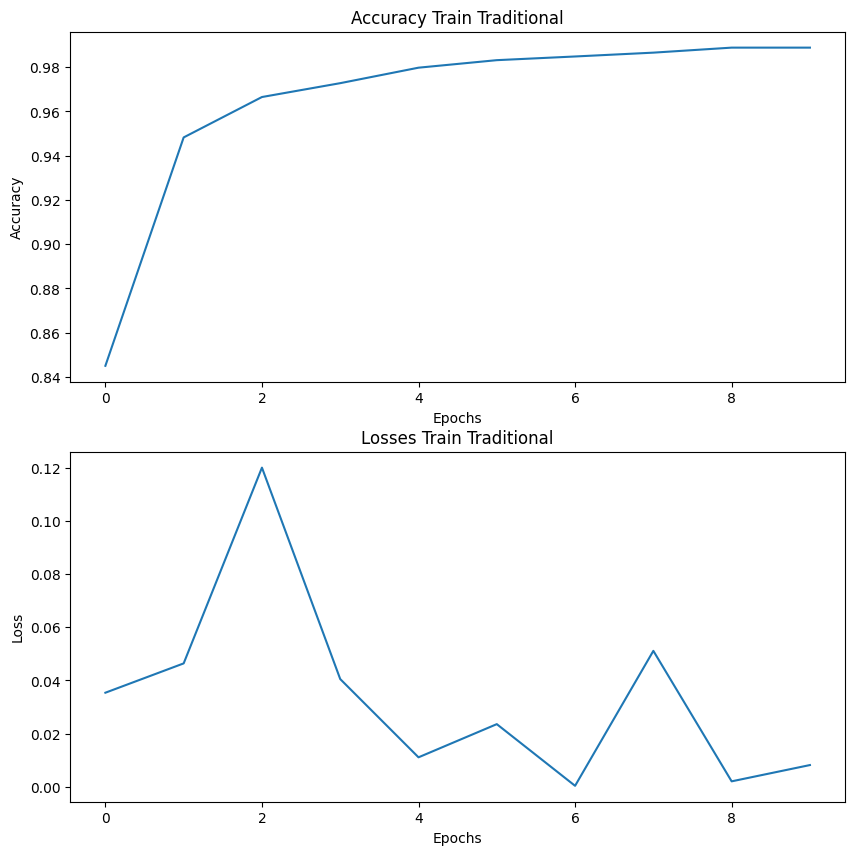

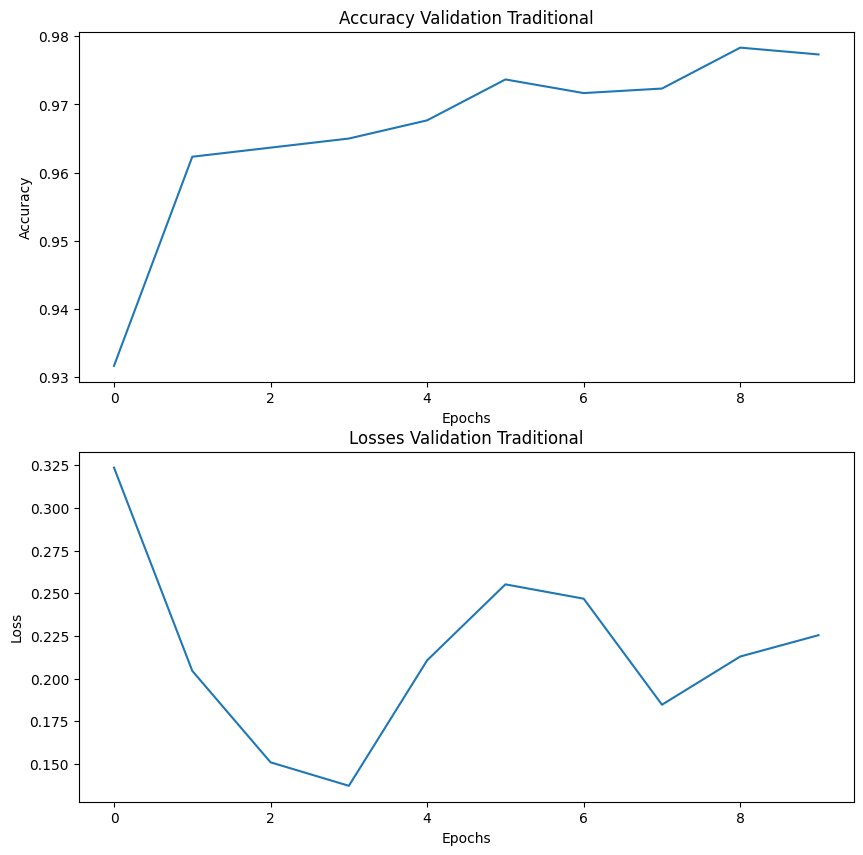

In [30]:
Traditional_required_time=toc-tic

Accuracy_test_Traditional=accuracy_for_test
Loss_Test_Traditional=loss_test

accuracy_val_Traditional=accuracy_val
losses_val_Traditional=losses_val

Accuracy_train_Traditional=accuracy_train
Losses_train_Traditional=losses_train


print("Required time for simulation for Traditional CNN:"+str(Traditional_required_time)+"s")




plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(Accuracy_train_Traditional)
plt.title("Accuracy Train Traditional")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")

plt.subplot(2,1,2)
plt.plot(Losses_train_Traditional)
plt.title("Losses Train Traditional")
plt.ylabel("Loss")
plt.xlabel("Epochs")



plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(accuracy_val_Traditional)
plt.title("Accuracy Validation Traditional")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")

plt.subplot(2,1,2)
plt.plot(losses_val_Traditional)
plt.title("Losses Validation Traditional")
plt.ylabel("Loss")
plt.xlabel("Epochs")

In [31]:
### Deformable CNN

# As I mentioned in the report of theoric questions, we need to consider offsets as some parameters and multiple these to
# the position of the samples of the grid and displace them.
# These offsets are learnable and during the training, we train it in an end-to-end form.
class DeformableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(DeformableConv2d, self).__init__()

        self.kernel_size = kernel_size
        self.padding = padding


        # We can consider 9 offsets for all samples of the kernels(kernels are 3 by 3) for all input channels. If the grid is h * w, we have h*w grid samples.
        # So we can update these parameters if we consider these samples as a conv layer with an arbitrary stride and padding and kernel size.
        # In fact we train the position of the offsets by help of a specific nn.Conv2d and we use for all possible kernels due to striding and paddings and finally
        # we multiple this grids to the Traditional Kernel.

        # Note that we have 2 offests for x and y directs, so the output channels must be 2*kernel_size*kernel_size.

        self.conv_offset = nn.Conv2d(in_channels, 2 * kernel_size * kernel_size, kernel_size=kernel_size, stride=stride, padding=padding)


        # We define conv_weight for the image for extracting features. But in the forward method, we multiple the offsets to this weights
        # And we finally use this weights instead of the module nn.Conv2d for extracting features in a layer.

        self.conv_weight = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)

        # We use this function for passing the scattered grid and find the best position by extracting features by using a nn.Conv2d as
        self.Conv_For_Grid= nn.Conv2d(kernel_size * kernel_size, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)

    def forward(self, x):
        #Calculating offsets
        offsets = self.conv_offset(x)

        # Generate grid for sampling
        # For every batch and channel, we consider grid_y and grid_x to construct the structured grid(they don't have irregular shapes yet)

        grid_y=offsets[:,:self.kernel_size*self.kernel_size, :, :]
        grid_x=offsets[:,self.kernel_size*self.kernel_size:, :, :]
        #Size of offests: (batchs,kernel**2,h,w)

        # Normalize grid to range [-1, 1]
        # According to the referenced article, we can define the R region in the interval of [-1,1], so if we normalize it we can construct this R
        grid_y = (2 * grid_y / (x.size(-2) - 1)) - 1
        grid_x = (2 * grid_x / (x.size(-1) - 1)) - 1

        sampled_features=(grid_x+grid_y)/2

        # After constructing the grid, we pass it from a network and it will be trained, so we can multiple this offsets to the
        # traditional kernel which is called "weights".
        sampled_features=self.Conv_For_Grid(sampled_features)
        weights = self.conv_weight(x)
        output = sampled_features * weights

        return output





In [32]:
# Define the CNN model
class DeformableConvolutionalNetwork(nn.Module):
    def __init__(self):
        super(DeformableConvolutionalNetwork, self).__init__()

        self.conv1=DeformableConv2d(1, 32, kernel_size=3, padding=1)
        self.relu=nn.ReLU()
        self.pool=nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2=DeformableConv2d(32, 64, kernel_size=3, padding=1)
        self.fc1=nn.Linear(64 * 7 * 7, 128)
        self.fc2=nn.Linear(128, 10)

    def forward(self, x):
        x=self.conv1(x)
        x=self.relu(x)
        x=self.pool(x)
        x=self.conv2(x)
        x=self.relu(x)
        x=self.pool(x)
        x=x.view(-1, 64 * 7 * 7)
        x=self.fc1(x)
        x=self.relu(x)
        x=self.fc2(x)
        return x

model = DeformableConvolutionalNetwork()

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
accuracy_train=np.zeros(num_epochs)
accuracy_val=np.zeros(num_epochs)
losses_train=np.zeros(num_epochs)
losses_val=np.zeros(num_epochs)
tic=time.time()
for epoch in range(num_epochs):
    model.train()
    acc=0
    all_samples=0
    for images,labels in train_dl:
        images=images.to(device)
        labels=labels.to(device)
        optimizer.zero_grad()
        outputs=model(images)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        _,predicted=torch.max(outputs,1)
        all_samples=all_samples+labels.size(0)
        acc=acc+(predicted==labels).sum().item()
    losses_train[epoch]=loss
    accuracy_train[epoch]=acc/all_samples
    # Validation loop
    model.eval()
    with torch.no_grad():
        acc=0
        all_samples=0
        for images,labels in val_dl:
            images=images.to(device)
            labels=labels.to(device)
            outputs=model(images)
            loss=criterion(outputs,labels)
            _,predicted=torch.max(outputs,1)
            all_samples=all_samples+labels.size(0)
            acc=acc+(predicted==labels).sum().item()
        losses_val[epoch]=loss
        accuracy_val[epoch]=acc/all_samples
        print("Epoch ",epoch,"\nLoss:",round(losses_val[epoch],4),"Accuracy:",round(accuracy_val[epoch],4))

toc=time.time()



with torch.no_grad():
    acc=0
    all_samples=0
    for images,labels in val_dl:
          images=images.to(device)
          labels=labels.to(device)
          outputs=model(images)
          loss=criterion(outputs,labels)
          _,predicted=torch.max(outputs,1)
          all_samples=all_samples+labels.size(0)
          acc=acc+(predicted==labels).sum().item()
    loss_test=loss
    accuracy_for_test = acc / all_samples
    print("Accuracy for Test:",round(accuracy_for_test,4))

Epoch  0 
Loss: 0.344 Accuracy: 0.9507
Epoch  1 
Loss: 0.1509 Accuracy: 0.953
Epoch  2 
Loss: 0.1257 Accuracy: 0.9747
Epoch  3 
Loss: 0.3271 Accuracy: 0.9667
Epoch  4 
Loss: 0.1416 Accuracy: 0.975
Epoch  5 
Loss: 0.258 Accuracy: 0.9753
Epoch  6 
Loss: 0.2723 Accuracy: 0.9753
Epoch  7 
Loss: 0.2023 Accuracy: 0.9737
Epoch  8 
Loss: 0.1937 Accuracy: 0.9767
Epoch  9 
Loss: 0.2228 Accuracy: 0.978
Accuracy for Test: 0.9807


Required time for simulation for Deformable CNN:471.28011870384216s


Text(0.5, 0, 'Epochs')

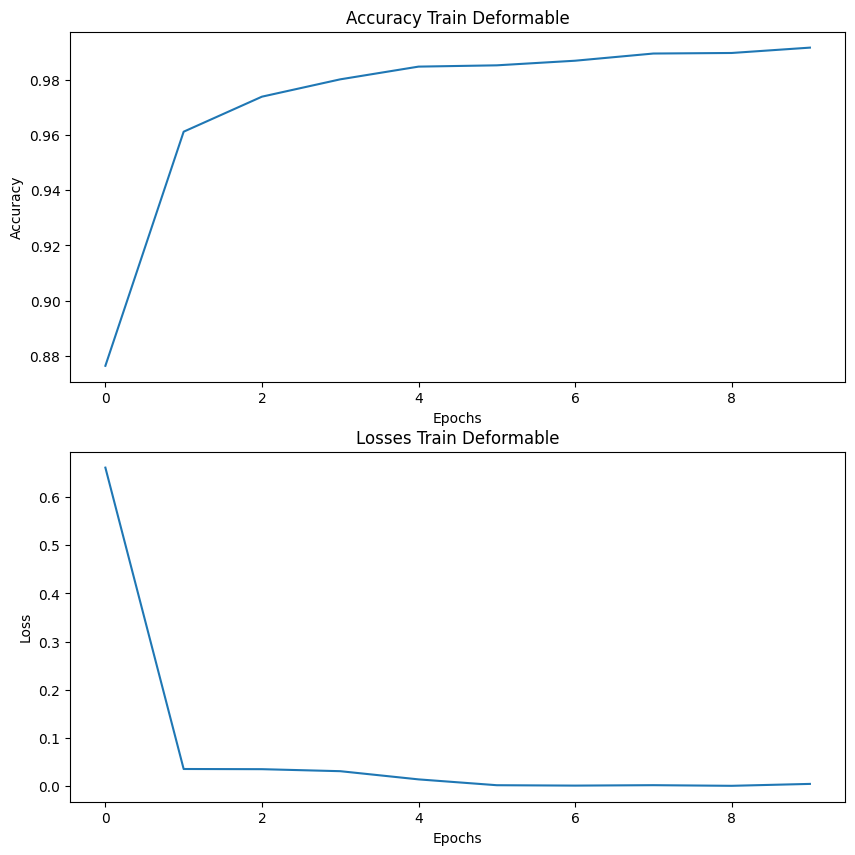

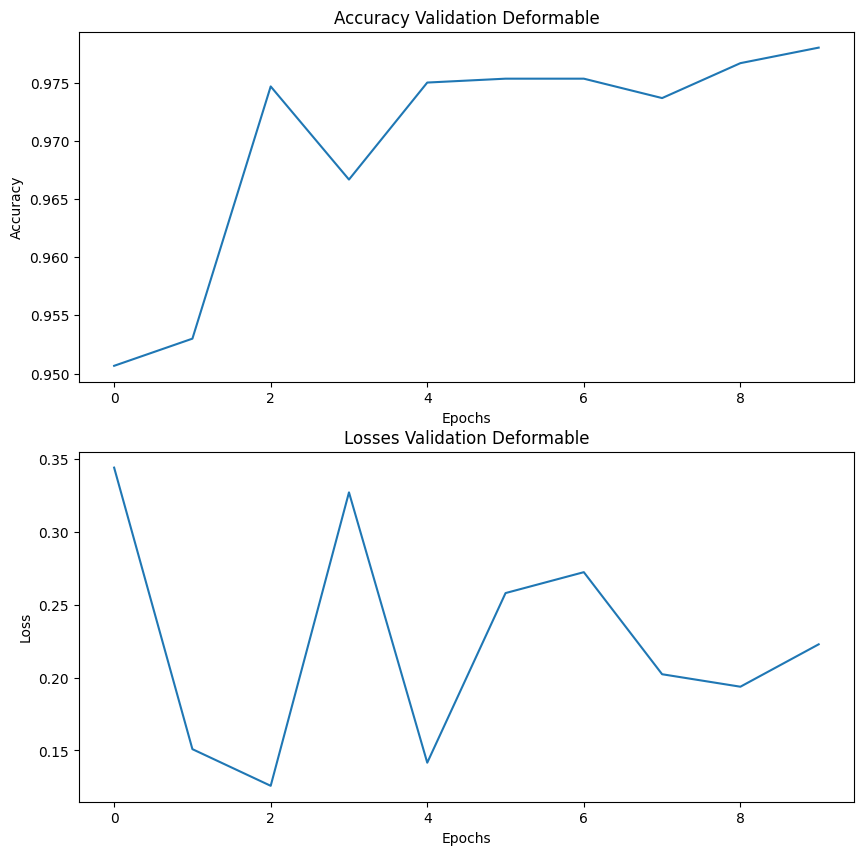

In [33]:
Deformable_required_time=toc-tic

Accuracy_test_Deformable=accuracy_for_test
Loss_Test_Deformable=loss_test

accuracy_val_Deformable=accuracy_val
losses_val_Deformable=losses_val

Accuracy_train_Deformable=accuracy_train
Losses_train_Deformable=losses_train


print("Required time for simulation for Deformable CNN:"+str(Deformable_required_time)+"s")




plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(Accuracy_train_Deformable)
plt.title("Accuracy Train Deformable")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")

plt.subplot(2,1,2)
plt.plot(Losses_train_Deformable)
plt.title("Losses Train Deformable")
plt.ylabel("Loss")
plt.xlabel("Epochs")



plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(accuracy_val_Deformable)
plt.title("Accuracy Validation Deformable")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")

plt.subplot(2,1,2)
plt.plot(losses_val_Deformable)
plt.title("Losses Validation Deformable")
plt.ylabel("Loss")
plt.xlabel("Epochs")

In [35]:
############# Comparing Two Methods
print("Accuracy for Deformable is  "+str(100*float(Accuracy_test_Deformable-Accuracy_test_Traditional))+"%  more than traditional CNN")
print("Required time for Deformable is  "+str(round(float(Deformable_required_time-Traditional_required_time),4))+"s  more than traditional CNN")




Accuracy for Deformable is  0.23333333333332984%  more than traditional CNN
Required time for Deformable is  219.3879s  more than traditional CNN
